Assignment 3: 

Name: Anuj Zore

UID: 119198457

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from functools import reduce
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 75.2MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [ ]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

X1 = np.zeros((252,2))
X2 = np.zeros((252,2))
for i in range(0,len(x1)):
  X1[i][0] = x1[i][0]
  X1[i][1] = y1[i][0]
  X2[i][0] = x2[i][0]
  X2[i][1] = y2[i][0] 

img1 = cv2.imread("/content/Part1_data/chapel00.png")
img2 = cv2.imread("/content/Part1_data/chapel01.png")

## Helper Functions

In [ ]:
# Funtion for computing fundamental matrix ---------------------------------------------------//

def approximate_Fundamental_Matrix(X1, X2):

  X1 = np.array(X1)
  X2 = np.array(X2)
  
  # Calculating mean for X1 and X2 -----------------------------------------------------------// 
  mn1 = np.sum(X1, axis=0) / X1.shape[0]
  mn2 = np.sum(X2, axis=0) / X2.shape[0]
  mn1 = np.reshape(mn1, (1, mn1.shape[0]))
  mn2 = np.reshape(mn2, (1, mn2.shape[0]))

  # Applying Translation ----------------------------------------------------------------------//
  translated_X1 = X1 - mn1
  translated_X2 = X2 - mn2    
  added_sqs1 = np.sum(translated_X1 ** 2, axis=1)
  added_sqs1 = np.reshape(added_sqs1, (translated_X1.shape[0], 1))
  mn_dist1 = np.sum(added_sqs1 ** (1 / 2), axis=0) / translated_X1.shape[0]
  factor1 = 2 ** (1 / 2) / mn_dist1[0]
  added_sqs2 = np.sum(translated_X2 ** 2, axis=1)
  added_sqs2 = np.reshape(added_sqs2, (translated_X2.shape[0], 1))
  mn_dist2 = np.sum(added_sqs2 ** (1 / 2), axis=0) / translated_X2.shape[0]
  factor2 = 2 ** (1 / 2) / mn_dist2[0]

  # Normalizing the translated X1 and X2 ------------------------------------------------------//
  nmlz1 = factor1 * translated_X1
  nmlz2 = factor2 * translated_X2
  translated_matrix1 = np.array([[1, 0, -mn1[0][0]], [0, 1, -mn1[0][1]], [0, 0, 1]])
  sc_matrix1 = np.array([[factor1, 0, 0], [0, factor1, 0], [0, 0, 1]])
  translated_matrix2 = np.array([[1, 0, -mn2[0][0]], [0, 1, -mn2[0][1]], [0, 0, 1]])
  sc_matrix2 = np.array([[factor2, 0, 0], [0, factor2, 0], [0, 0, 1]])
  
  # Normalized --------------------------------------------------------------------------------//
  T1 = np.dot(sc_matrix1, translated_matrix1)
  T2 = np.dot(sc_matrix2, translated_matrix2)


  A = np.zeros((X1.shape[0], 9))
  for i in range(X1.shape[0]):
    A[i, :] = [nmlz2[i][0] * nmlz1[i][0], nmlz2[i][0] * nmlz1[i][1], nmlz2[i][0], nmlz2[i][1] * nmlz1[i][0], nmlz2[i][1] * nmlz1[i][1], nmlz2[i][1], nmlz1[i][0], nmlz1[i][1], 1]

  # Applying Singular Value Decomposition -----------------------------------------------------//
  U, S, Vt = np.linalg.svd(A)

  V = Vt.T
  V = V[:, -1]
  F = np.zeros((3, 3))
  count = 0
  for i in range(3):
    for j in range(3):
      F[i, j] = V[count]
      count += 1

  u, s, vt = np.linalg.svd(F)

  # Enforce det(f) = 0 -----------------------------------------------------------------------//
  s[-1] = 0
  newS = np.zeros((3, 3))
  for i in range(3):
    newS[i, i] = s[i]

  newF = np.dot((np.dot(u, newS)), vt)

  regF = np.dot(np.dot(T2.T, newF), T1)
  regF = regF / regF[-1, -1]

  return regF

# Function for calculating fundamental matrix with 8-point Algorithm -------------------------//
def RANSAC(feature1, feature2):
  # Defining threshold and iteration ---------------------------------------------------------//
  thresh = 0.05
  prsntInliers = 0
  perfF = []
  p = 0.99
  N = 2000
  count = 0
  while count < N:
    inlier_count = 0
    random_feature1 = []
    random_feature2 = []
    RandList = np.random.randint(len(feature1), size=8)
    for k in RandList:
      random_feature1.append(feature1[k])
      random_feature2.append(feature2[k])

    # Calculating fundamental matrix for current random sample points -------------------------//
    F = approximate_Fundamental_Matrix(random_feature1, random_feature2)
    One = np.ones((len(feature1), 1))
    X_1 = np.hstack((feature1, One))
    X_2 = np.hstack((feature2, One))
    E_1, E_2 = X_1 @ F.T, X_2 @ F

    # Calculating the error -------------------------------------------------------------------//
    err = np.sum(E_2 * X_1, axis=1, keepdims=True) ** 2 / np.sum(np.hstack((E_1[:, :-1], E_2[:, :-1])) ** 2, axis=1,
                                                                  keepdims=True)
    Inl = err <= thresh
    InlCnt = np.sum(Inl)

    # Comparing with threshold ----------------------------------------------------------------//
    if prsntInliers < InlCnt:
      prsntInliers = InlCnt
      coor = np.where(Inl == True)
      x1_ar = np.array(feature1)
      x2_ar = np.array(feature2)
      inlier_x1 = x1_ar[coor[0][:]]
      inlier_x2 = x2_ar[coor[0][:]]
      perfF = F

    RatioInl = InlCnt / len(feature1)
    if np.log(1 - (RatioInl ** 8)) == 0: continue
    N = np.log(1 - p) / np.log(1 - (RatioInl ** 8))
    count += 1
  return perfF, inlier_x1, inlier_x2

# Function generating random points for RANSAC feed ------------------------------------------//
def randomPts(pt1_list, pt2_list, val):
  index = []
  for i in range(val):
    num = random.randint(0,len(pt1_list)-1)
    index.append(num)
  new_pts1 = []
  new_pts2 = []
  for i in range(len(index)):
    val = index[i]
    new_pts1.append(pt1_list[val])
    new_pts2.append(pt2_list[val])
  
  new_pts1 = np.asarray(new_pts1)
  new_pts2 = np.asarray(new_pts2)
  return new_pts1, new_pts2

  
# Function for displaying epilines ---------------------------------------------------------------//
def drawlines(img1,lines, pts):
  i1 = img1.copy()
  r,c,_ = img1.shape
  for r, pt1 in zip(lines, pts):
    color1=(0,255,0)
    color2 = (0,0,255)
    x0,y0 = map(int, [0, -r[2]/r[1]])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    i1 = cv2.line(i1, (x0,y0), (x1,y1), color1 ,1)
    i1 = cv2.circle(i1, tuple(pt1), 2, color2, -1)
  return i1

In [ ]:
# Result ----------------------------------------------------------------------------------------//

X1 = []
X2 = []

for i in range(len(x1)):
  temp = [x1[i][0], y1[i][0]]
  X1.append(temp)

for i in range(len(x2)):
  temp2 = [x2[i][0], y2[i][0]]
  X2.append(temp2)

F, pt1, pt2 = RANSAC(X1, X2)
print("Fundamenal Matrix: \n", F)

points1, points2 = randomPts(pt1, pt2, 7)

ones = np.ones((points1.shape[0], 1))
final_X1 = np.append(points1, ones, axis=1)
final_X2 = np.append(points2, ones, axis=1)

lines1 = np.dot(F, final_X1.T)
lines2 = np.dot(final_X2, F)

i1 = drawlines(img2, lines1.T, points2)
i2 = drawlines(img1, lines2, points1)

final_image = np.hstack((i1, i2))
cv2_imshow(final_image)

In [ ]:
normalized_F = F / np.sqrt(np.sum(F**2))
print(normalized_F)

### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.
*   Display the estimated fundamental matrix F after normalizing to unit length
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



**1] Describe what test you used for deciding inlier vs. outlier.**


Answer: The number of inliner correspondences are counted for randomly sampled fundamental matrix. Appropriate threshold is used to compare the distance of intrest points i.e. xFx'. Fundamental matrix with the most inliners will be returened as the chosen F. 

Below are the parameters considered for this section:
1.   Threshold: 0.05
2.   Iterations: 2000
3.   Total inliners for Best_F: 252





**2]  Display the estimated fundamental matrix F after normalizing to unit length**

Estimated Fundamental Matrix: 

In [ ]:
print(F)

Normalised Fundamental Matrix after normalising to unit length:

In [ ]:
# Normalising Fundamental matrix to unit length --------------------------------------------//
normalized_F = F / np.sqrt(np.sum(F**2))
print(normalized_F)

**3] Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.**

In [ ]:
# Selecting random 7 sets of matching points ------------------------------------------------//
points1, points2 = randomPts(pt1, pt2, 7)

ones = np.ones((points1.shape[0], 1))
final_X1 = np.append(points1, ones, axis=1)
final_X2 = np.append(points2, ones, axis=1)

# Calculating the lines -----------------------------------------------------------------------//
lines1 = np.dot(F, final_X1.T)
lines2 = np.dot(final_X2, F)

# Drawing lines -------------------------------------------------------------------------------//
i1 = drawlines(img2, lines1.T, points2)
i2 = drawlines(img1, lines2, points1)

# Displaying Image ----------------------------------------------------------------------------//
final_image = np.hstack((i1, i2))
cv2_imshow(final_image)

### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


## Helper Functions

In [ ]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(img1 , kp_1 , img2 , kp_2 , matches):
    good_draw = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_draw.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1, kp_1 , img2 , kp_2 , good_draw,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    h = V[-1,:]/V[-1,-1]
    h = np.array(h)
    return np.reshape(h ,(3 ,3 ))

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

### Code (15 pt)

In [ ]:
# Function implementing RANSAC for removing incorrect matches --------------------------------------//
def ransac_H(src , dst , good_matches):
    threshold = 1
    iterations = 50
    best_count = 0 
    H_final = np.zeros((3,3))
    best_dist = np.inf

    normalize_src_x , normalize_src_y , T_src_normalize = normalize_kp(src , good_matches)
    normalize_src = np.hstack((normalize_src_x.reshape(-1 ,1) , normalize_src_y.reshape(-1 ,1)))

    normalize_dst_x , normalize_dst_y , T_dst_normalize = normalize_kp(dst , good_matches)
    normalize_dst = np.hstack((normalize_dst_x.reshape(-1 ,1) , normalize_dst_y.reshape(-1 ,1)))

    for i in range(iterations): 
        rand_4 = np.random.randint( 0 , good_matches , size = 4)
        src_4 = np.vstack((  normalize_src[rand_4[0] ,:] , normalize_src[rand_4[1] ,:] , normalize_src[rand_4[2] ,:] , normalize_src[rand_4[3] ,:] ))
        dst_4 = np.vstack((  normalize_dst[rand_4[0] ,:] , normalize_dst[rand_4[1] ,:] , normalize_dst[rand_4[2] ,:] , normalize_dst[rand_4[3] ,:] ))
    
        H = est_homography( src_4 , dst_4 )
        dst_after_homography = apply_homography(H , normalize_src)

        # Computing L2 norm ------------------------------------------------------------------------//
        dist = np.linalg.norm(dst_after_homography - normalize_dst , axis =1)
        dis_sum = np.sum(dist)

        inlier_find = np.where( dist<threshold , 1 , 0)
        count = np.sum(inlier_find)

        # Updating inliners ------------------------------------------------------------------------//
        if count>best_count or (count==best_count and dis_sum<best_dist):
            best_count = count
            best_dist = dis_sum
            H_final = H

    # Denormalizing H matrix
    H_recapture = np.linalg.inv(T_dst_normalize) @ H_final @ T_src_normalize

    return H_recapture 

# Generating Match Pairs ------------------------------------------------------------------//
def good_matches(i1 , i2 , dst_right_img):   
    img1_copy = i1.copy()
    img2_copy = i2.copy()
        
    sift = cv2.SIFT_create()

    kp_1, des_1 = sift.detectAndCompute(img1_copy,None)
    kp_2, des_2 = sift.detectAndCompute(img2_copy,None)

    bf = cv2.BFMatcher()
    
    if dst_right_img:
        matches = bf.knnMatch(des_1 ,des_2, k=2)

        # Implementing ratio test ----------------------------------------------------------//
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance:
                good.append(m)
   
        if len(good)>10:
            src_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)  

    else :
        matches = bf.knnMatch(des_2 ,des_1, k=2)

        # Lowe's ratio test ----------------------------------------------------------------//
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance:
                good.append(m)
 
        if len(good)>10:
            src_pts = np.float32([ kp_2[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_1[m.trainIdx].pt for m in good ]).reshape(-1,1,2) 

    plot_matches(img1_copy , kp_1 , img2_copy , kp_2 , matches)
    return src_pts , dst_pts , len(good)


# Function for normalising keypoints -------------------------------------------------------//
def normalize_kp(pts, good_matches):
    x_mean = np.mean(pts[: , 0 , 0])
    y_mean = np.mean(pts[: , 0 , 1])

    orig_xy = np.hstack((  pts[: , 0 , 0].reshape(-1 ,1) , pts[: , 0 , 1].reshape(-1 ,1)))
    std_check = np.std(orig_xy)

    #Tranformation matrix -----------------------------------------------------------------//
    Transformation_matrix = np.array([ [(np.sqrt(2)/std_check) , 0 , -(x_mean*np.sqrt(2)/std_check)] ,
                        [ 0 , (np.sqrt(2)/std_check) , -(y_mean*np.sqrt(2)/std_check)] ,
                        [ 0 , 0 , 1]    ] )

    # Reshaping --------------------------------------------------------------------------//
    points = np.vstack((  pts[: , 0 , 0].reshape(1,-1), pts[: , 0 , 1].reshape(1,-1) ,  np.ones((1 , good_matches))))

    pts_norm = np.matmul(Transformation_matrix, points)

    # Normalized -------------------------------------------------------------------------//
    pts_norm_x = pts_norm[0 , :]
    pts_norm_y = pts_norm[1 , :] 

    return pts_norm_x , pts_norm_y , Transformation_matrix

# Function for stiching the given Images -------------------------------------------------//
def stitch_images(img1 , img2 , img3):  
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    # Zero padding ------------------------------------------------------------------------//
    middle_img = np.zeros((img1_gray.shape[0] , img1_gray.shape[1]+img2_gray.shape[1]) , dtype = np.uint8)
    middle_img[: , img1_gray.shape[1]:] = img2_gray
    src , dst , match_count = good_matches(img1_gray , middle_img , True)
    H_1 = ransac_H(src , dst , match_count)

    print(f"Best H for img 1 and img 2\n{H_1}")

    # Image warping -----------------------------------------------------------------------//
    dst = cv2.warpPerspective(img1 ,H_1,(img1.shape[1] + img2.shape[1], img2.shape[0]))
    dst[:, img2.shape[1]:] = img2
    src_2 , dst_2 , match_count_2 = good_matches(dst, img3_gray, False)
    H_2 = ransac_H(src_2 , dst_2 , match_count_2)

    print(f"Best H for img 2 and img 3\n{H_2}")

    # Final warping ------------------------------------------------------------------------//
    merged = cv2.warpPerspective(img3 , H_2,(dst.shape[1] + img3_gray.shape[1], img3_gray.shape[0]))
    merged[:, :dst.shape[1]] = dst

    # Displaying Result --------------------------------------------------------------------//
    plt.figure()
    plt.figure(figsize = (15, 15))
    plt.imshow(merged ,cmap = 'gray')

    return H_1, H_2

In [ ]:
# Main Code --------------------------------------------------------------------------------//

# Feeding given images ----------------------------//
first_image = cv2.imread('/content/hill/1.JPG' )  
second_image = cv2.imread('/content/hill/2.JPG' )
third_image = cv2.imread('/content/hill/3.JPG' )

# Stiching given images ---------------------------//
H_1, H_2 = stitch_images(first_image , second_image, third_image)

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC 
*  Display the best homography H after RANSAC 
*  Display the blended images

**1] Describe how to remove incorrect matches with RANSAC**




1.   Checking the key points distance with threshold and calculating the number of inliners.


```
 for i in range(iterations): 
        rand_4 = np.random.randint( 0 , good_matches , size = 4)
        src_4 = np.vstack((  normalize_src[rand_4[0] ,:] , normalize_src[rand_4[1] ,:] , normalize_src[rand_4[2] ,:] , normalize_src[rand_4[3] ,:] ))
        dst_4 = np.vstack((  normalize_dst[rand_4[0] ,:] , normalize_dst[rand_4[1] ,:] , normalize_dst[rand_4[2] ,:] , normalize_dst[rand_4[3] ,:] ))
    
        H = est_homography( src_4 , dst_4 )
        dst_after_homography = apply_homography(H , normalize_src)

        # Computing L2 norm ------------------------------------------------------------------------//
        dist = np.linalg.norm(dst_after_homography - normalize_dst , axis =1)
        dis_sum = np.sum(dist)

        inlier_find = np.where( dist<threshold , 1 , 0)
        count = np.sum(inlier_find)

```


2.    Homograpghy matrix with maximum number of inliners are saved in H_final (Best Homography Matrix) along with inliner counts.



```
# Updating inliners ------------------------------------------------------------------------//
        if count>best_count or (count==best_count and dis_sum<best_dist):
            best_count = count
            best_dist = dis_sum
            H_final = H
```



3.    Choosen inliner is employed in further process.


**2] Display the best homography H after RANSAC**

In [ ]:
# Displaying Best Homography for Image 1 and Image 2 ---------------------------------------//
print(f"Best H for img 1 and img 2\n{H_1}")

In [ ]:
# Displaying Best Homography for Image 2 and Image 3 --------------------------------------//
print(f"Best H for img 2 and img 3\n{H_2}")

**3] Blended image**

In [ ]:
H_1, H_2 = stitch_images(first_image , second_image, third_image)

### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
!rm -rf Part2_data.zip
!rm -rf Part2_data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 210MB/s]
Archive:  /content/Part2_data.zip
   creating: /content/Part2_data/
   creating: /content/Part2_data/images/
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2_data/images/hot

### Code (20 pt)

In [ ]:
from numpy import linalg as la
def isPD(B):
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False
def nearestPD(A):
    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [ ]:
track_x = data['track_x']
track_y = data['track_y']

from scipy import linalg
import scipy

def centerCoordinates(track_x, track_y):
  centered_x = np.zeros(track_x.shape)
  centered_y = np.zeros(track_y.shape)

  for i in range(track_x.shape[1]):
    centroid_x = np.sum(track_x[:,i])/len(track_x[:,i])
    centroid_y = np.sum(track_y[:,i])/len(track_y[:,i])
    centered_x[:,i] = track_x[:,i]-centroid_x
    centered_y[:,i] = track_y[:,i]-centroid_y

  return centered_x, centered_y

def cleanTrackPoints(track_x, track_y):
  resolved_x = np.nan_to_num(track_x)
  resolved_y = np.nan_to_num(track_y)

  print(resolved_x)
  print(resolved_y)
  
  return resolved_x, resolved_y

def affineSFM(track_x, track_y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  centered_X, centered_Y = centerCoordinates(track_x, track_y)
  measurement_Matrix = np.zeros((2*centered_X.shape[1], centered_X.shape[0]))
  for i in range(centered_X.shape[1]):
    measurement_Matrix[i,:] = centered_X[:,i]
  for i in range(centered_X.shape[1]):
    measurement_Matrix[i+centered_X.shape[1],:] = centered_Y[:,i]

  # SVD
  u,w,v = np.linalg.svd(measurement_Matrix, full_matrices = True)

  u_3 = u[:,0:3]
  w_3 = np.zeros((3,3))
  v_3 = v[0:3, :]
  for i in range(3):
    w_3[i,i] = w[i]

  w_root = linalg.sqrtm(w_3)
  a_prime = u_3 @ w_root
  x_prime = w_root @ v_3

  def generateColumn(v1,v2):
    [a,b,c] = v1
    [d,e,f] = v2
    res = [a*d, b*d, c*d, a*e, b*e, c*e, a*f, b*f, c*f]
    return res

  a_prime_i = a_prime[:centered_X.shape[1],:]
  a_prime_j = a_prime[centered_X.shape[1]:,:]

  def equationFormer(leftMatrix, rightColumn, R1, R2, valueforRightColumn):
      rightColumn.fill(valueforRightColumn)
      n = R1.shape[0]
      for i in range(n):
        r1 = R1[i, :]
        r2 = R2[i, :]
        res = generateColumn(r1,r2)
        leftMatrix[i, :] = res

      return leftMatrix, rightColumn

  m1,k1 = equationFormer(np.zeros((centered_X.shape[1], 9)), np.zeros((centered_X.shape[1], 1)),a_prime_i, a_prime_i, 1)
  m2,k2 = equationFormer(np.zeros((centered_X.shape[1], 9)), np.zeros((centered_X.shape[1], 1)),a_prime_j, a_prime_j, 1)
  m3,k3 = equationFormer(np.zeros((centered_X.shape[1], 9)), np.zeros((centered_X.shape[1], 1)),a_prime_i, a_prime_j, 0)

  leftMatrix = np.vstack((m1,m2,m3))
  rightColumn = np.vstack((k1,k2,k3))
  rightColumn = rightColumn.squeeze()

  l = np.linalg.lstsq(leftMatrix, rightColumn, rcond=None)[0]

  L = np.zeros((3,3))

  L[0][0] = l[0]
  L[1][0] = l[1]
  L[2][0] = l[2]
  L[0][1] = l[3]
  L[1][1] = l[4]
  L[2][1] = l[5]
  L[0][2] = l[6]
  L[1][2] = l[7]
  L[2][2] = l[8]

  L = nearestPD(L)
  
  C = np.linalg.cholesky(L)
  # print(l)
  # print(L)
  scipy.linalg.cholesky(L, lower=True)
  Aret = np.dot(a_prime, C)
  Xret = np.dot(np.linalg.inv(C), x_prime)
  return Aret, Xret

cleanedX, cleanedY = cleanTrackPoints(track_x, track_y)
A,X = affineSFM(cleanedX, cleanedY)
X = X.T
print(X.shape)

[[201.         201.19923266 201.39260081 ... 214.14622823 214.50362938
  214.98713309]
 [255.         255.56389819 255.88661684 ... 276.03912157 276.52184558
  277.09578362]
 [165.         165.05581785 165.15324359 ... 172.95607661 173.23759997
  173.59030403]
 ...
 [488.         487.33052687 486.32465387 ...   0.           0.
    0.        ]
 [337.         337.87251031 338.49508458 ... 362.46875441 362.90183082
  363.50184019]
 [383.         383.54276015 384.13284722 ... 404.31813262 404.60621991
  404.94788903]]
[[243.         243.08051765 242.95833596 ... 227.29577988 226.82431023
  226.35145579]
 [261.         261.3382253  261.19186593 ... 247.90862236 247.59609777
  247.20678636]
 [230.         229.91649654 229.80212738 ... 212.22570809 211.67580599
  211.15843872]
 ...
 [442.         442.77370494 444.93576045 ...   0.           0.
    0.        ]
 [246.         246.5310715  246.94158172 ... 258.26639623 258.44820101
  258.7129412 ]
 [217.         217.40892375 218.2978678  ... 254

In [ ]:
X1 = X[:,0]
Y1 = X[:,1]
Z1 = X[:,2]

factor = 1
pointcloud = np.zeros((X1.shape[0], 3))
pointcloud[:, 0] = X1
pointcloud[:, 1] = Y1
pointcloud[:, 2] = Z1 * factor



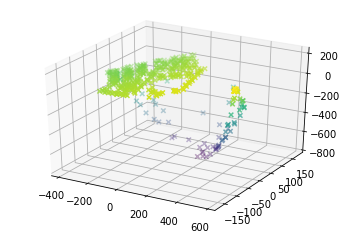

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(pointcloud[:, 0],   # x
           pointcloud[:, 1],   # y
           pointcloud[:, 2],   # z
           c=pointcloud[:, 2], # height data for color,
           marker="x")

In [ ]:
AT = np.transpose(A)

In [ ]:
import plotly.graph_objects as go
import numpy as np

X = A[:,0]
Y = A[:,1]
Z = A[:,2]
# Helix equation
# t = np.linspace(0, 10, 50)

fig = go.Figure(data=[go.Scatter3d(x=X, y=Y, z=Z,
                                   mode='markers')])
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

X = AT[0]
Y = AT[1]
Z = AT[2]
# Helix equation
# t = np.linspace(0, 10, 50)

fig = go.Figure(data=[go.Scatter3d(x=X, y=Y, z=Z,
                                   mode='markers')])
fig.show()

### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992